In [5]:
import json
import os
import cv2
import numpy as np
import random
from amodal_utils import get_bbox_from_mask, save_image, get_image_paths_from_folder
from visualization_utils import visualize_merged_amodal_and_modal, visualize_all_masks
from config import INPUT_PATHS, OUTPUT_PATHS, HYPERPARAMETERS

#### Merged image generation

In [14]:
def merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_mask, offset_y=0):

    cucumber_bbox = get_bbox_from_mask(cucumber_mask)
    # 오이 객체 중심 계산
    cuc_center_x = (cucumber_bbox[0] + cucumber_bbox[2]) // 2
    cuc_center_y = (cucumber_bbox[1] + cucumber_bbox[3]) // 2
    
    # 잎 이미지의 크기와 위치 계산
    leaf_h, leaf_w = leaf_image.shape[:2]
    leaf_x = cuc_center_x - leaf_w // 2
    leaf_y = cuc_center_y + offset_y - leaf_h // 2

    # 이미지 병합 (투명 배경 유지)
    result_image = cucumber_image.copy()

    # 잎에 대한 segmentation mask 생성 (0으로 채운 마스크를 생성하고, 잎이 있는 부분만 255로 설정)
    leaf_mask = np.zeros((cucumber_image.shape[0], cucumber_image.shape[1]), dtype=np.uint8)

    for i in range(leaf_h):
        for j in range(leaf_w):
            # 잎 이미지의 알파 채널을 고려하여 합성
            if leaf_image[i, j, 3] > 0:  # 알파 채널이 0보다 크면 (투명하지 않다면)
                result_image[leaf_y + i, leaf_x + j] = leaf_image[i, j, :3]  # RGB 채널만 병합
                leaf_mask[leaf_y + i, leaf_x + j] = 255  # 잎의 마스크 부분을 255로 설정

    return result_image, leaf_mask #(leaf_x, leaf_y, leaf_x + leaf_w, leaf_y + leaf_h)


def synthesize_two_images(cucumber_image_path, leaf_image_path, cucumber_mask, offset_y=0, save_dir=None, image_index=0):
    # 오이 이미지와 잎 이미지 로드
    cucumber_image = cv2.imread(cucumber_image_path, cv2.IMREAD_UNCHANGED)
    leaf_image = cv2.imread(leaf_image_path, cv2.IMREAD_UNCHANGED)

    # 이미지를 합성
    merged_image, leaf_mask = merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_mask,  offset_y)

    # 결과 이미지 파일 저장 경로 설정
    cucumber_image_name = os.path.basename(cucumber_image_path)
    # 결과 이미지 파일 저장 경로 설정
    merged_image_name = f"{os.path.splitext(cucumber_image_name)[0]}_merged_{str(image_index).zfill(2)}.png"
    merged_image_path = save_image(save_dir, merged_image_name, merged_image)
    
    return merged_image_path, leaf_mask  # 저장된 이미지 경로와 새로운 bbox 반환


##### amodal mask info (occluder, occuluded)

In [15]:
# modal 마스크 생성
def generate_modal_mask(cucumber_mask, leaf_mask, image_name, save_dir):
    # 겹치는 부분 (오이 마스크와 잎 마스크가 동시에 255인 부분을 추출)
    overlap_mask = (cucumber_mask == 255) & (leaf_mask == 255)
    
    # Modal 마스크 생성 (겹치는 부분을 제외한 오이 마스크)
    modal_mask = cucumber_mask.copy()
    modal_mask[overlap_mask] = 0  # overlap 영역을 0으로 만들어 겹친 부분 제거

    #visualize_all_masks(cucumber_mask, leaf_mask, modal_mask)

    # 마스크를 PNG 형식으로 저장 (이진화된 값 0 또는 255로 저장)
    mask_filename = f"{os.path.splitext(image_name)[0]}_modal_mask.png"
    save_image(save_dir, mask_filename, modal_mask)

    return modal_mask, overlap_mask

# Occlusion 정보 수집 및 저장
def save_amodal_info_to_json(image_name, objects_info, json_dir, occluded_area_percent=None, occluded_mask=None):
    json_data = {
        "image_name": image_name,
        "objects": []
    }
    
    for obj in objects_info:
        obj_data = {
            "id": obj["id"],
            "class": obj["class"],
            "mask_path": obj["mask_path"],
            "occlusion": obj["occlusion"],
            "occluder_id": obj.get("occluder_id", None),  # 가리는 객체 ID
            "occluded_id": obj.get("occluded_id", None)   # 가려지는 객체 ID
        }
        
        # 만약 객체가 가려진 경우, occlusion 정보를 추가
        if obj["occlusion"]:
            obj_data["occluded_area"] = occluded_area_percent  # 퍼센트 비율로 가려진 영역 저장

            ## 가려진 영역 마스크 저장
            # if occluded_mask is not None:
            #     obj_data["occluded_mask"] = occluded_mask.tolist()  # 마스크를 리스트로 변환하여 저장
        
        json_data["objects"].append(obj_data)

    # JSON 파일 저장
    json_filename = os.path.splitext(image_name)[0] + "_amodal_info.json"
    json_path = os.path.join(json_dir, json_filename)

    with open(json_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=4)
    
    print(f"JSON 파일 저장됨: {json_path}")


def calculate_occluded_area_percent(cucumber_mask, overlap_mask):
    total_cucumber_area = np.sum(cucumber_mask == 255)
    occluded_area = np.sum(overlap_mask)
    
    if total_cucumber_area == 0:
        return 0.0  # 만약 오이 마스크가 없으면, 0%
    
    return occluded_area / total_cucumber_area



In [16]:
def process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, save_dir, mask_save_dir, json_dir, image_index, offset_y=0):
    # 1. 오이 마스크 불러오기
    cucumber_mask = cv2.imread(cucumber_mask_path, cv2.IMREAD_GRAYSCALE)
    
    print("오이 이미지 합성 시작...")
    # 2. 오이 이미지에 잎 이미지를 합성하고 저장
    merged_image_path, leaf_mask = synthesize_two_images(cucumber_image_path, leaf_cropped_image_path, cucumber_mask, offset_y, save_dir, image_index)

    print("Modal 마스크 생성 시작...")
    # 4. Modal 마스크 생성 및 겹치는 부분 (가림) 정보 계산
    modal_mask, overlap_mask = generate_modal_mask(cucumber_mask, leaf_mask, os.path.basename(merged_image_path), mask_save_dir)
    amodal_mask = cucumber_mask

    print("Modal 정보 저장 시작...")
     # 5. 가려진 영역의 비율 계산
    occluded_area_percent = calculate_occluded_area_percent(cucumber_mask, overlap_mask)
    
    # 6. 객체 정보 저장 (bbox 및 occlusion 정보)
    objects_info = [
        {
            "id": 1,  # 오이 객체 ID
            "class": "cucumber",
            "mask_path": cucumber_mask_path,  # 오이 마스크 파일 경로
            "occlusion": True,  # 오이가 가려짐
            "occluder_id": 2,  # 잎에 의해 가려짐
        },
        {
            "id": 2,  # 잎 객체 ID
            "class": "leaf",
            "mask_path": leaf_cropped_image_path,  # 잎 마스크 파일 경로
            "occlusion": False,  # 잎은 가리지 않음
            "occluded_id": 1  # 오이를 가림
        }
    ]

    # 8. 최종적으로 합성된 이미지와 amodal 마스크 저장
    save_amodal_info_to_json(os.path.basename(merged_image_path), objects_info, json_dir, occluded_area_percent, overlap_mask)
    visualize_merged_amodal_and_modal(cv2.imread(merged_image_path, cv2.IMREAD_UNCHANGED), amodal_mask, modal_mask)
#

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/oi_002_1_merged_30.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks/oi_002_1_merged_30_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/oi_002_1_merged_30_amodal_info.json


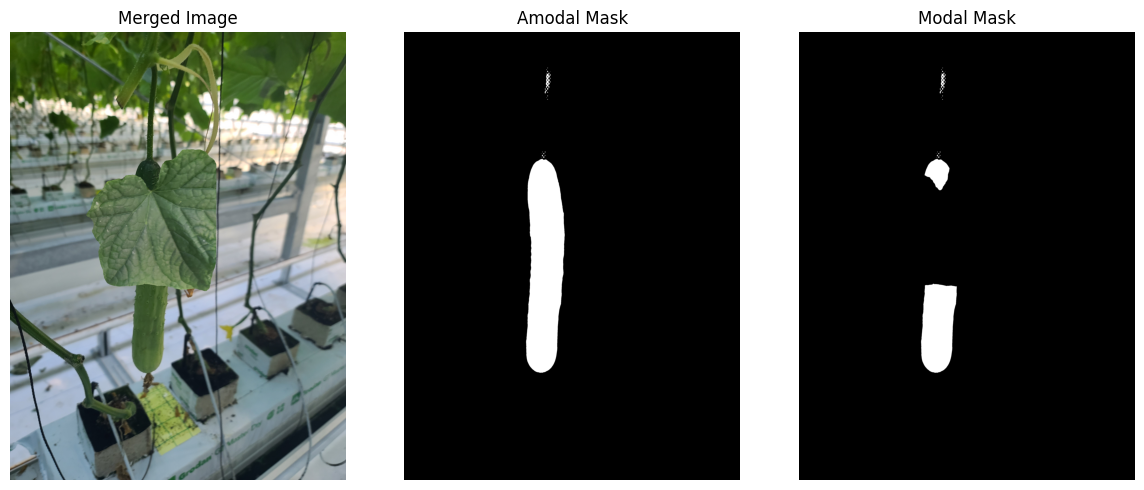

In [17]:
# 실행 예시
''' input'''
cucumber_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/images/oi_002_1.jpg"
leaf_cropped_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_029_3_1_00.png"
cucumber_mask_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/masks/oi_002_1_0_00.png"


''' output dir'''
save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images"
mask_save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks"
json_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info"
offset_y = 30
image_index = 0
#
process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, save_dir, mask_save_dir, json_dir, image_index, offset_y)

#### Multiple Generation Code

oi_140_3에 대한 1개의 마스크 확보...
71 개의 잎 이미지와 합성 시작...
오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


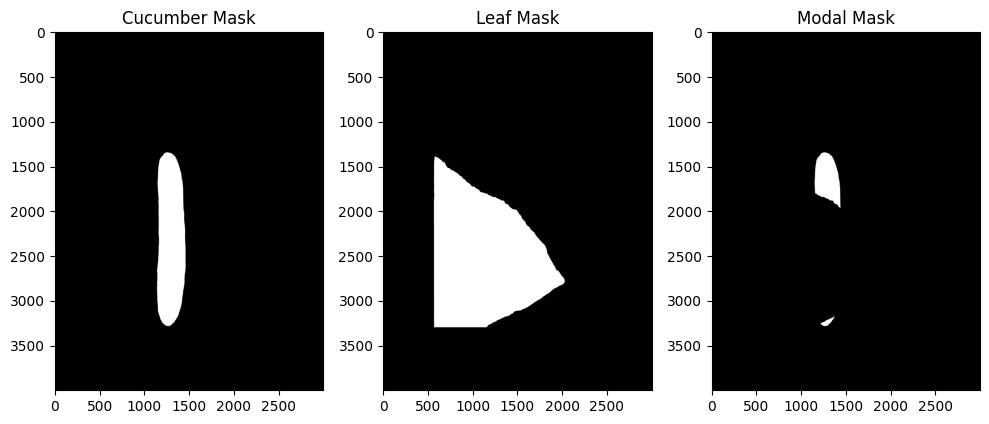

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


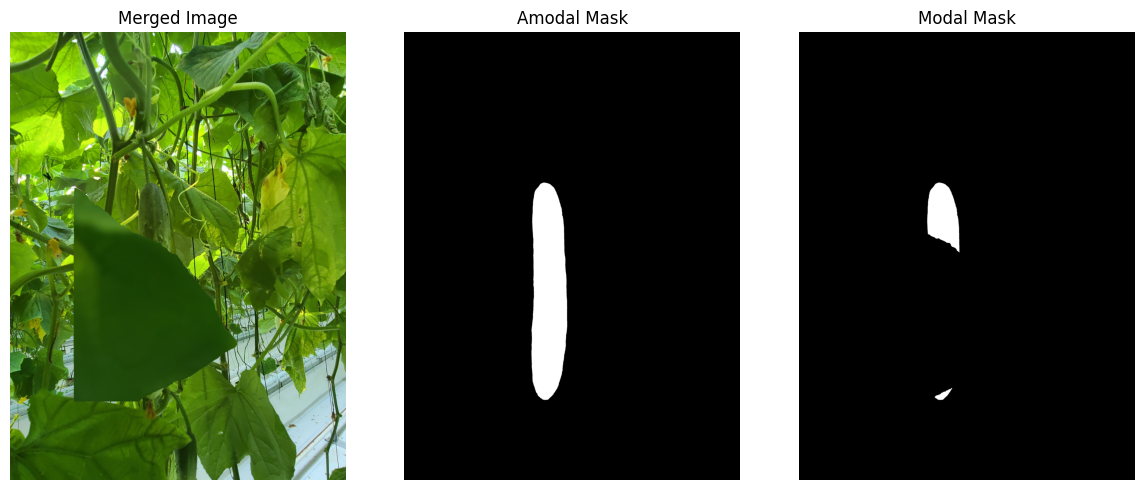

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


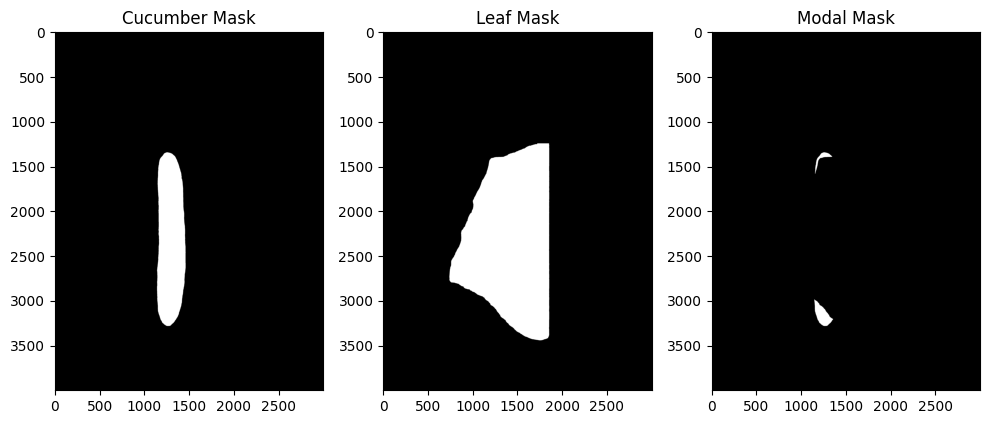

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


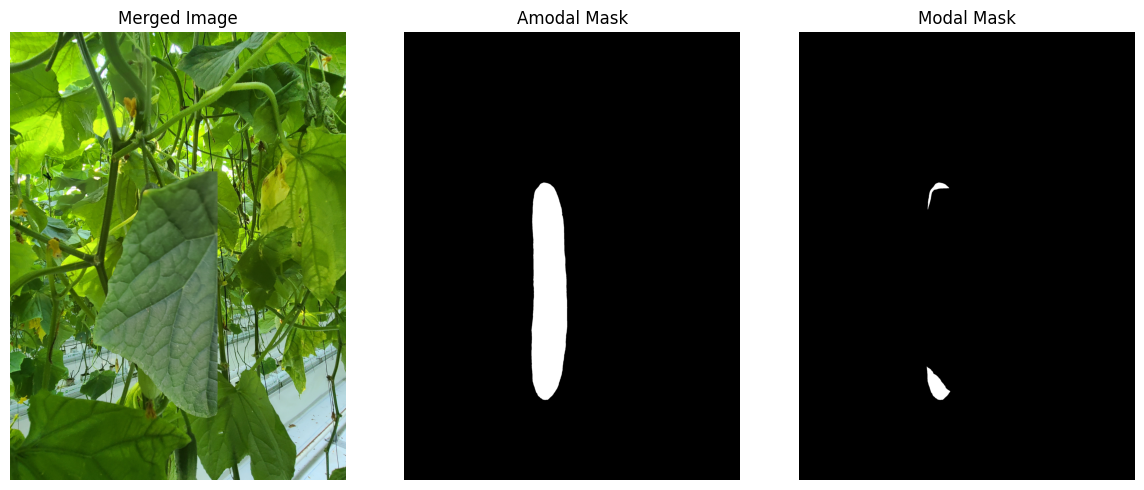

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


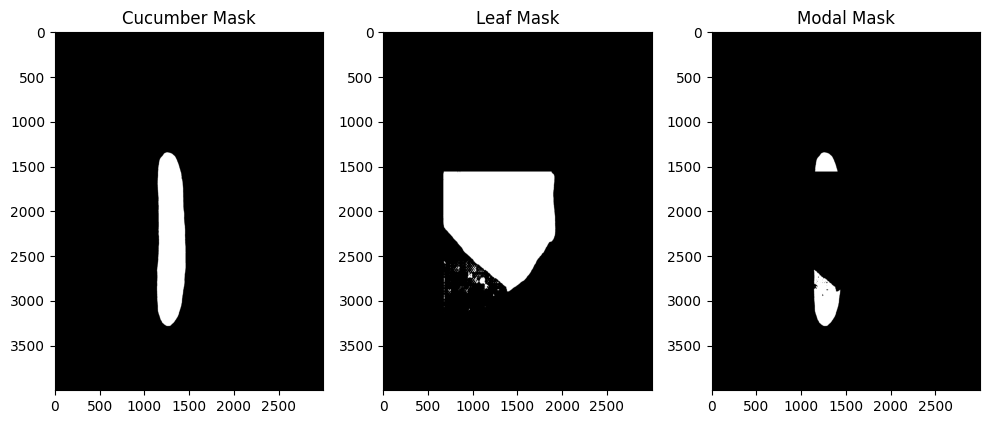

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


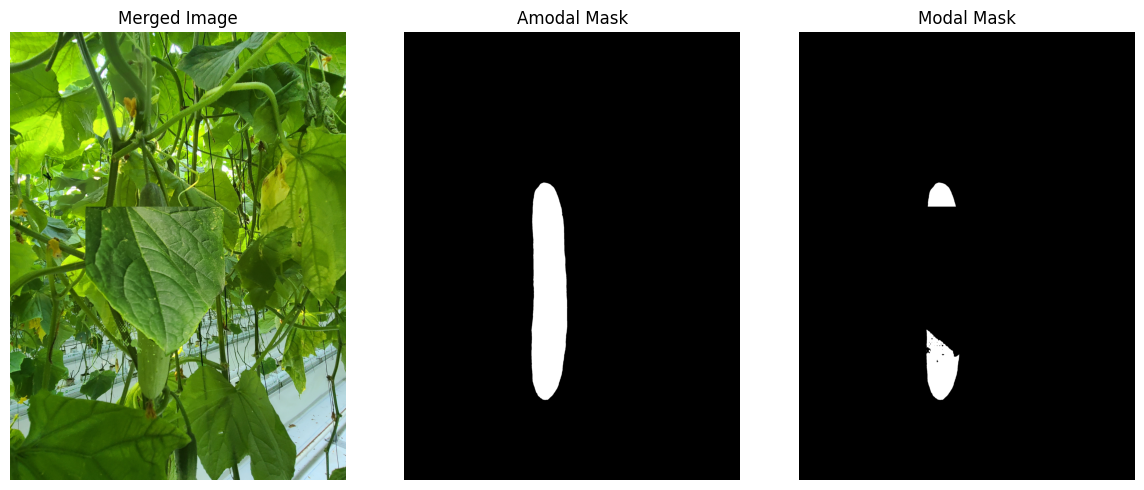

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


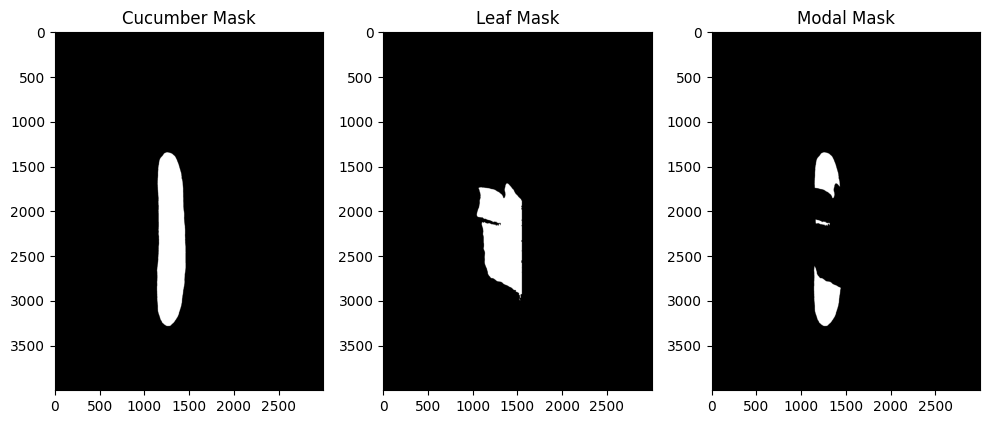

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


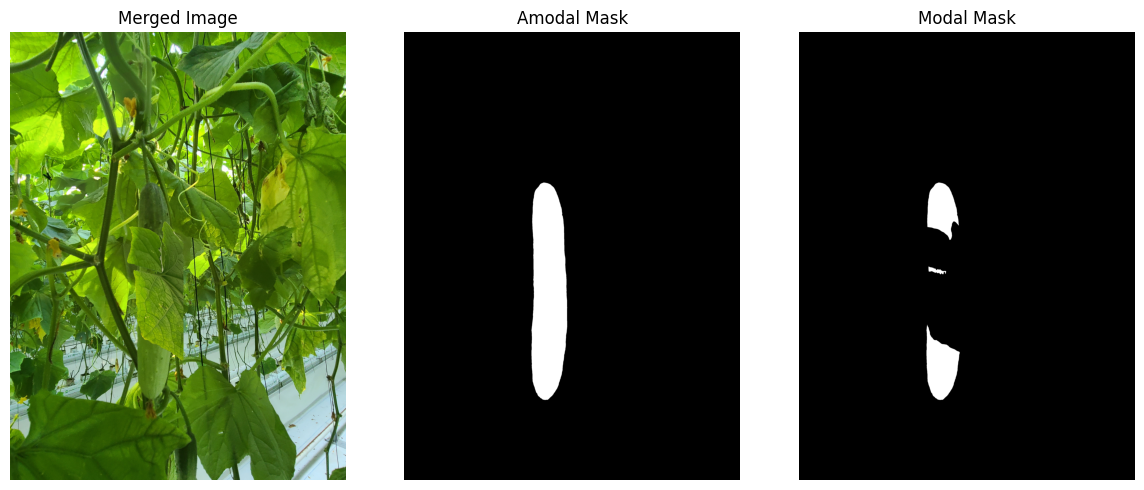

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


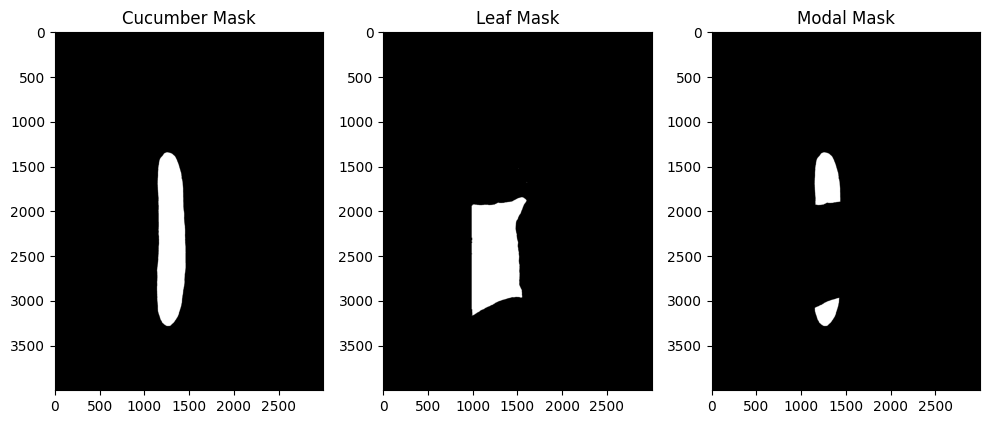

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


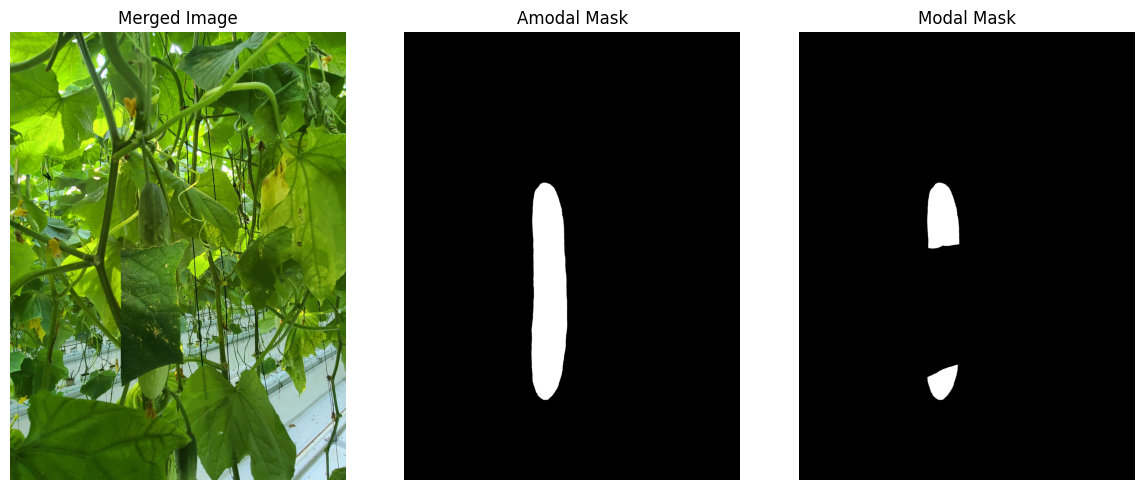

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


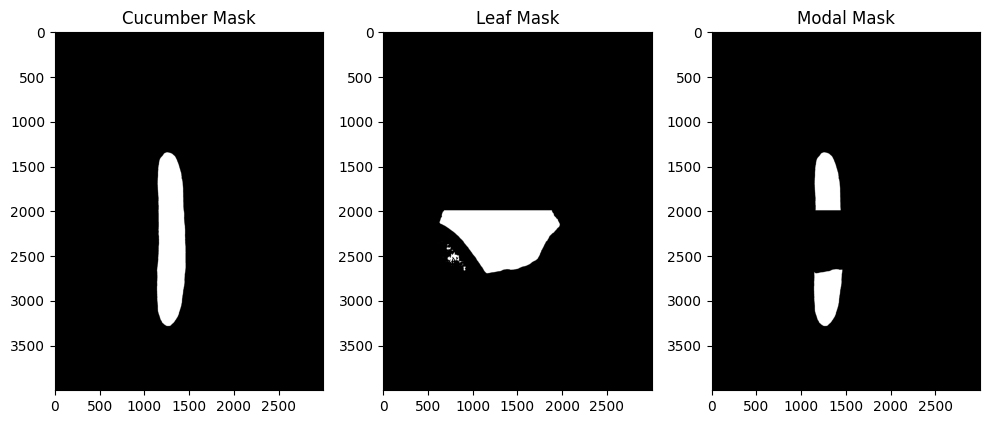

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


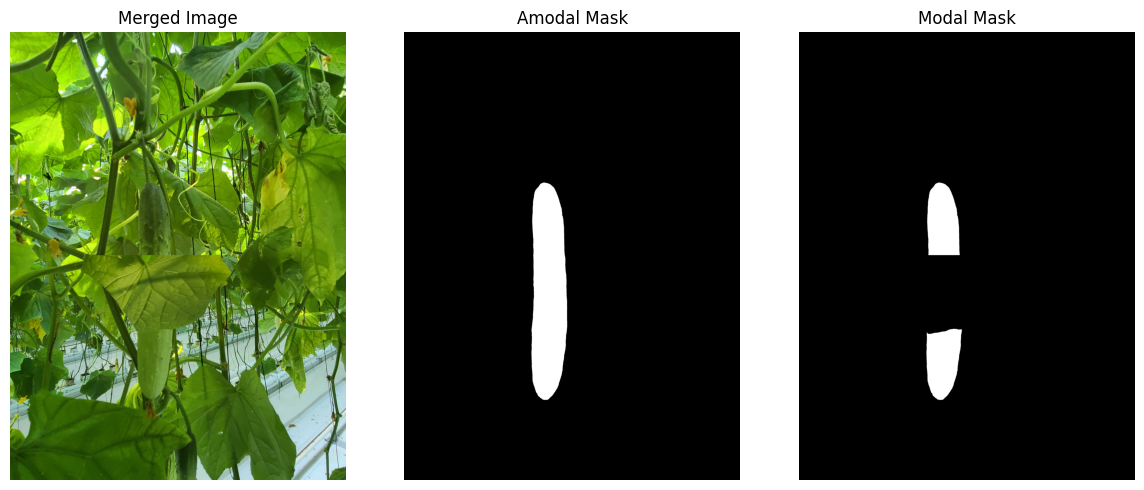

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


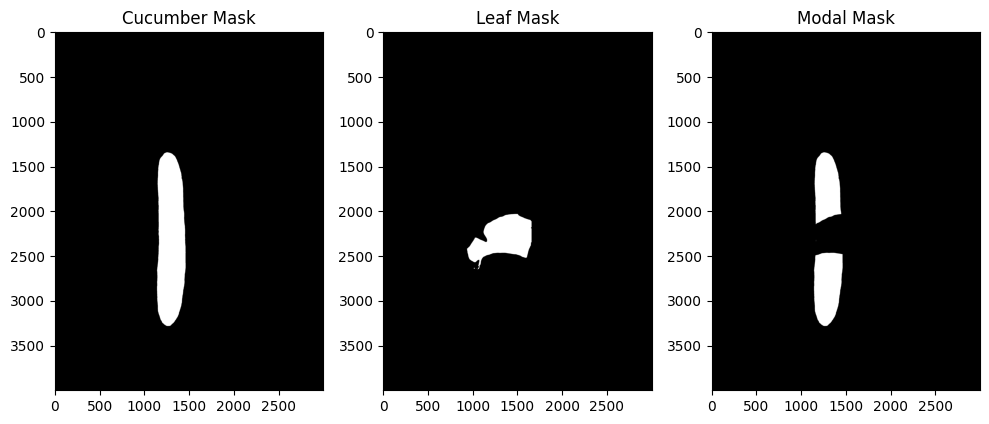

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


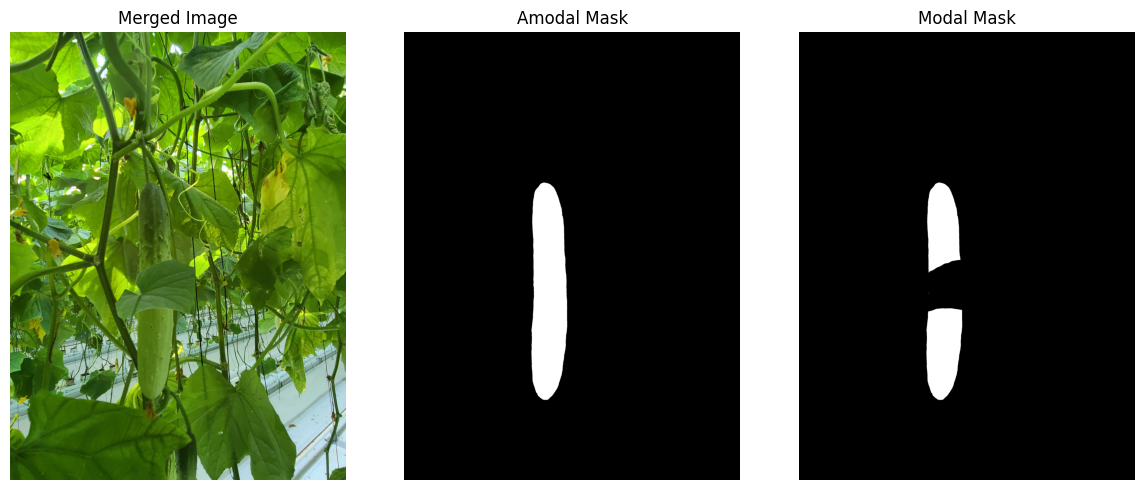

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


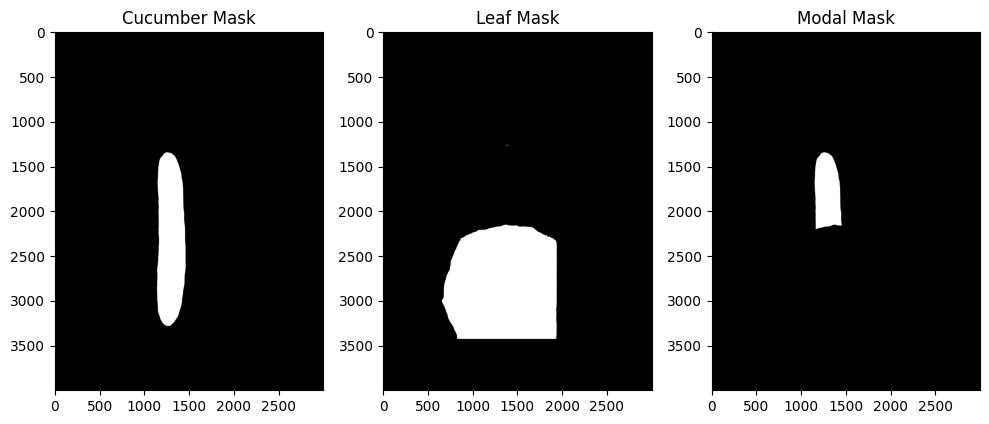

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


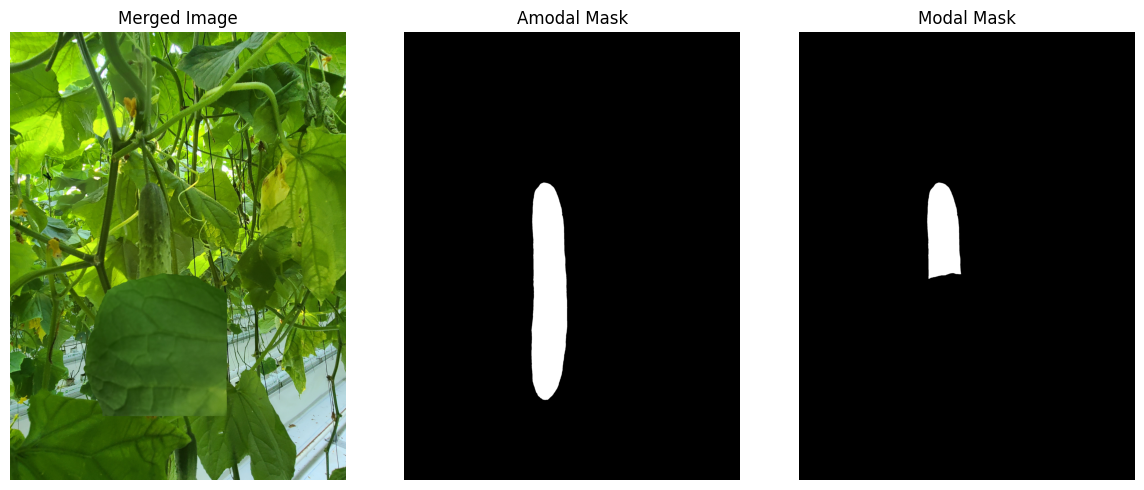

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


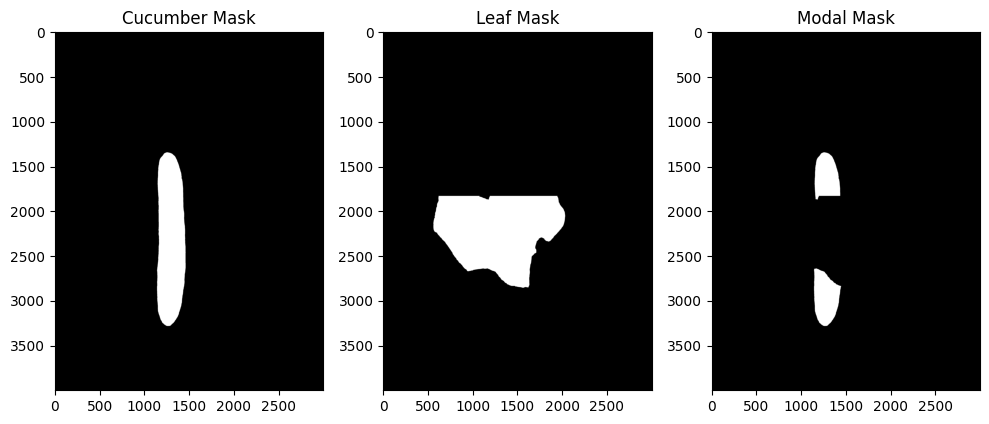

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


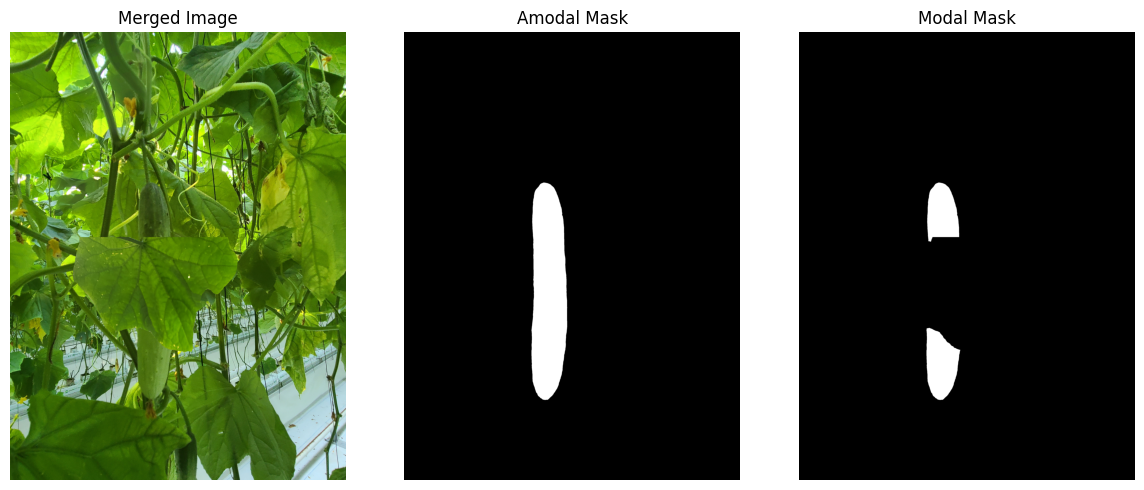

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


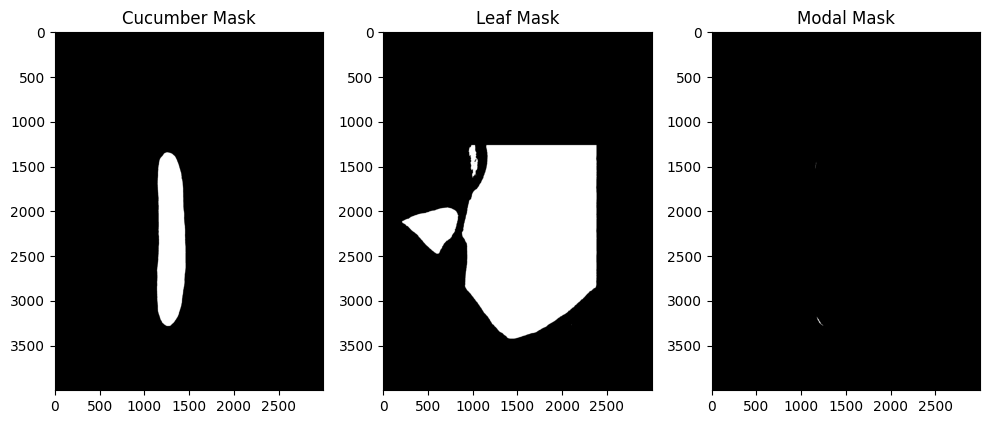

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


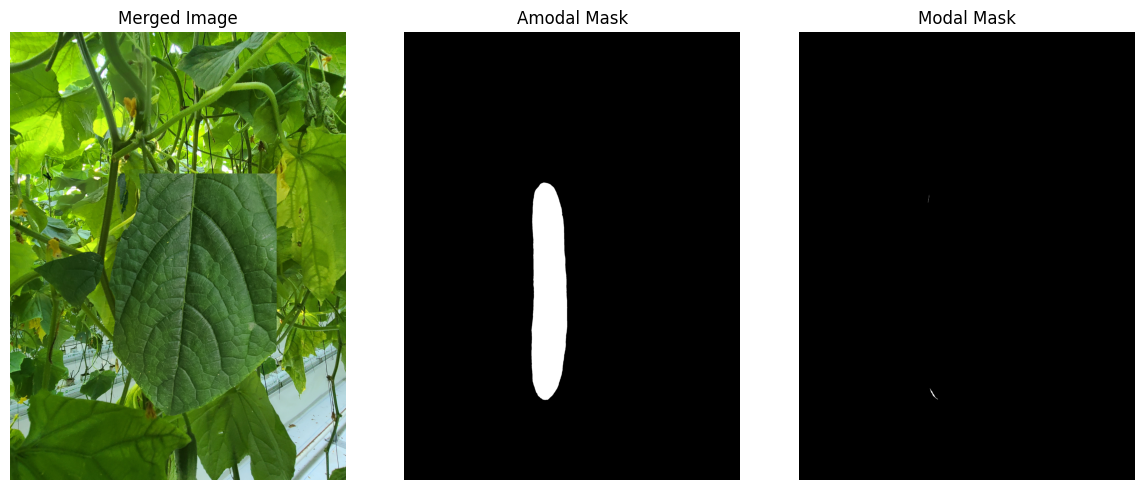

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


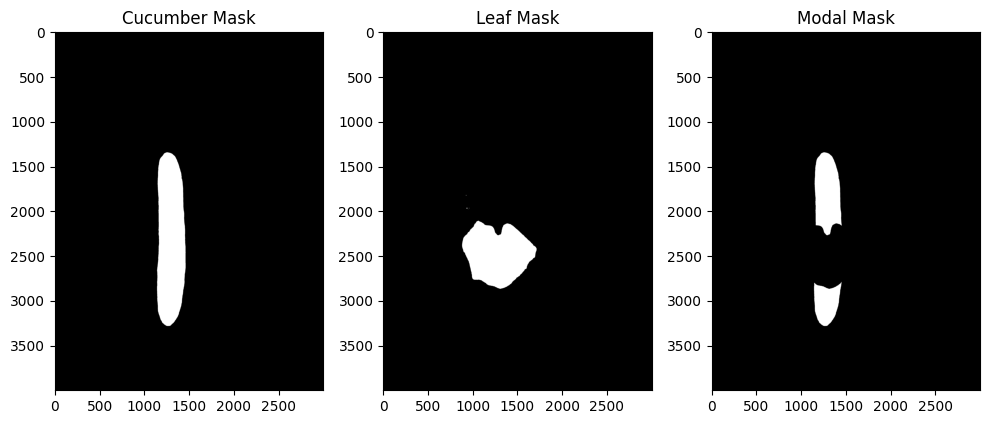

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


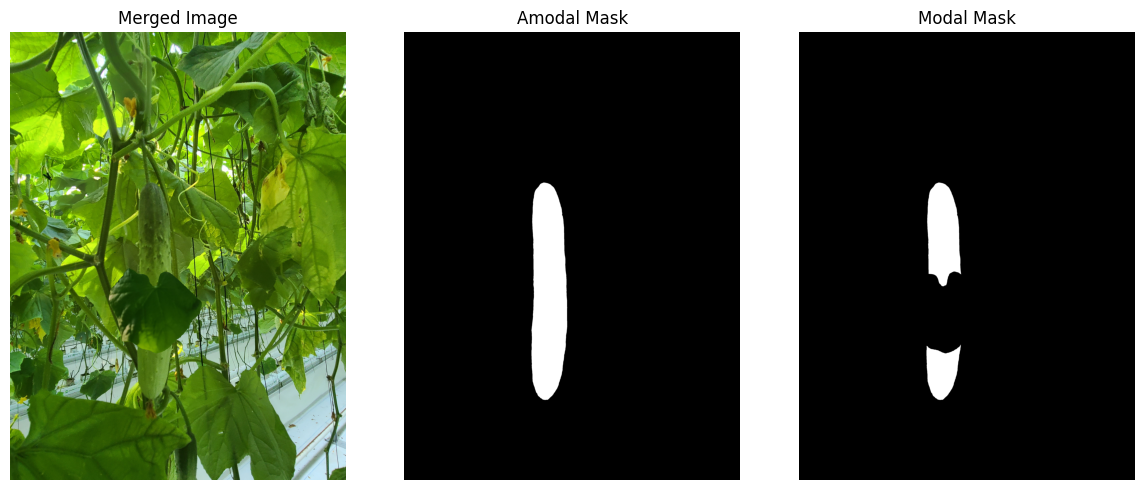

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


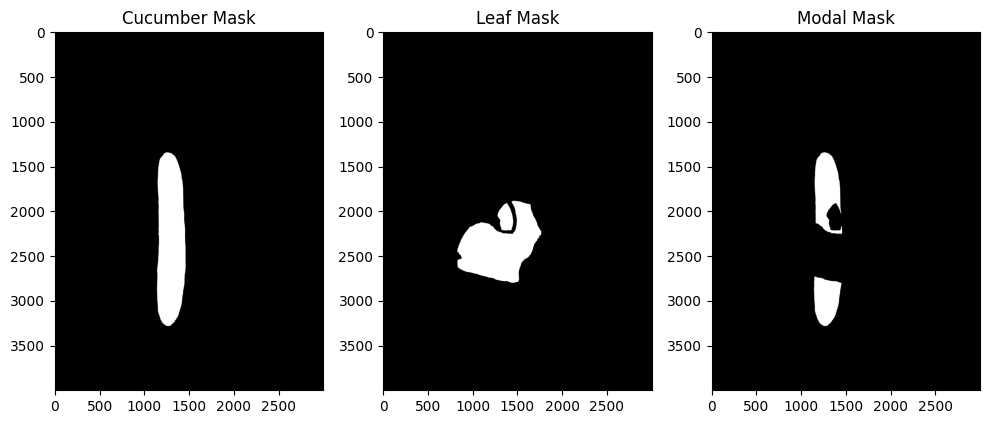

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


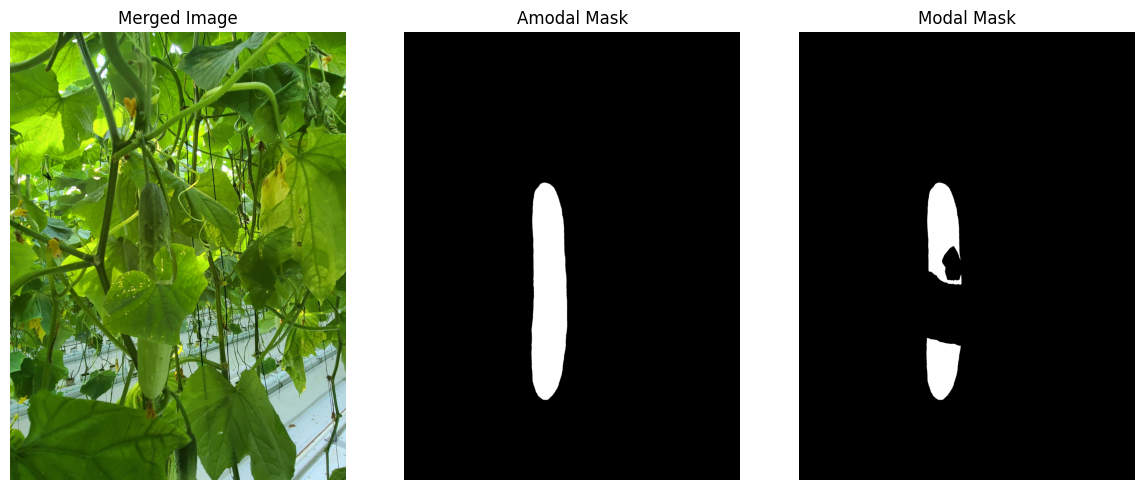

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


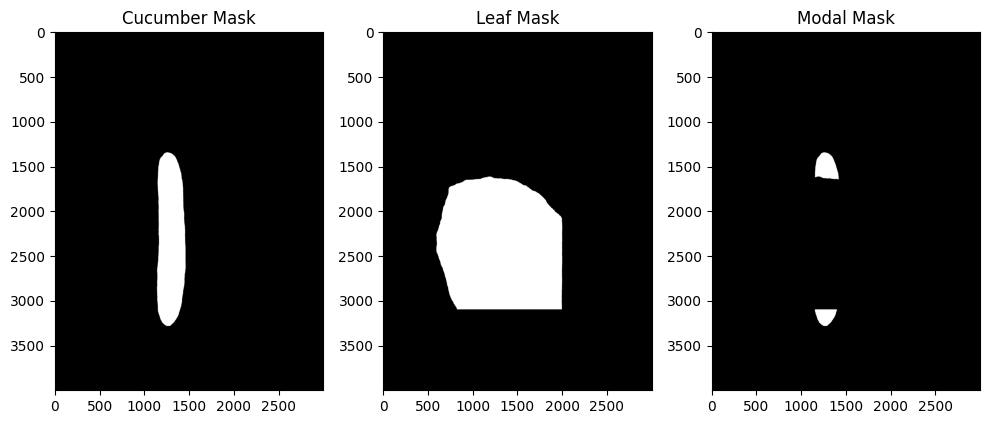

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


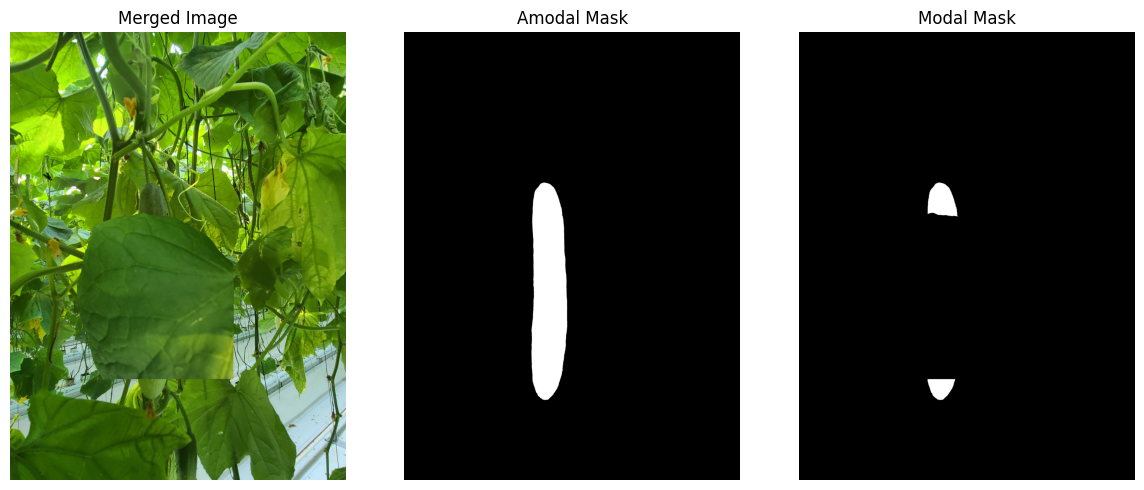

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


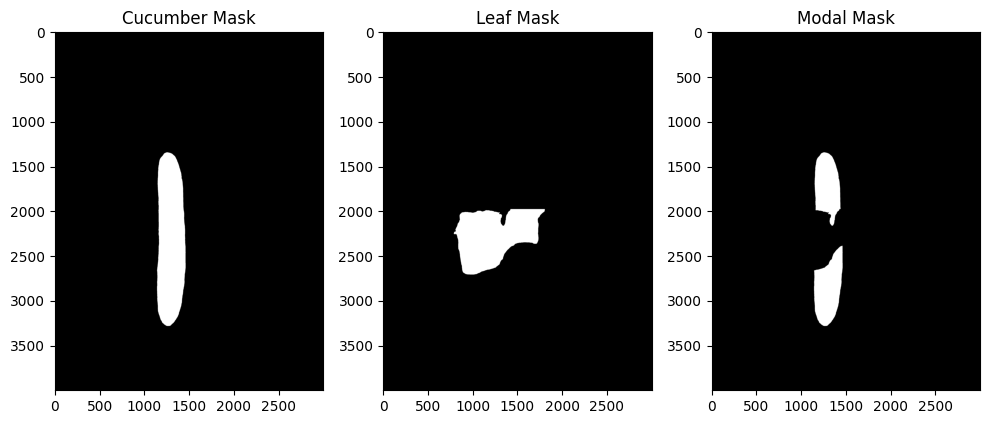

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


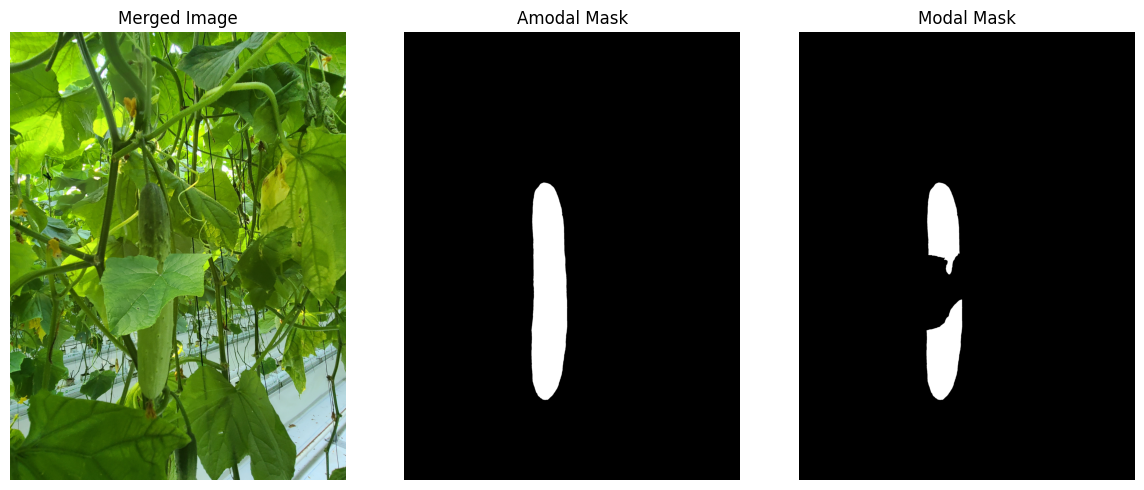

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


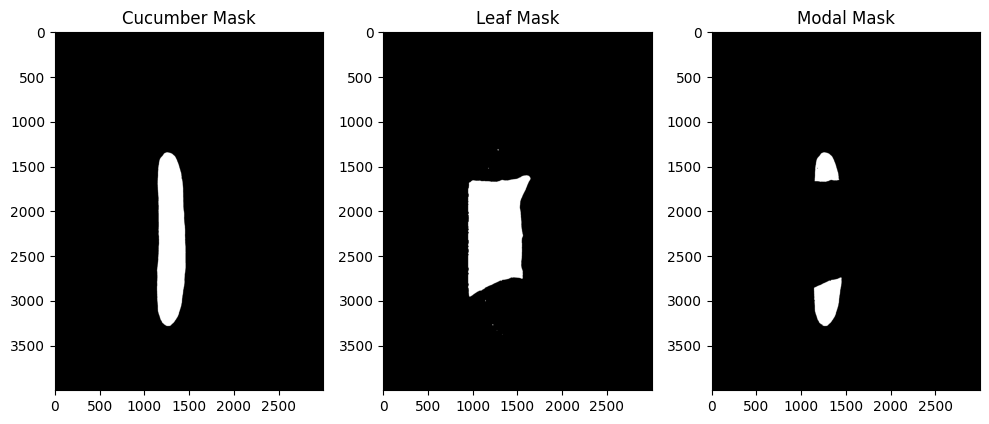

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


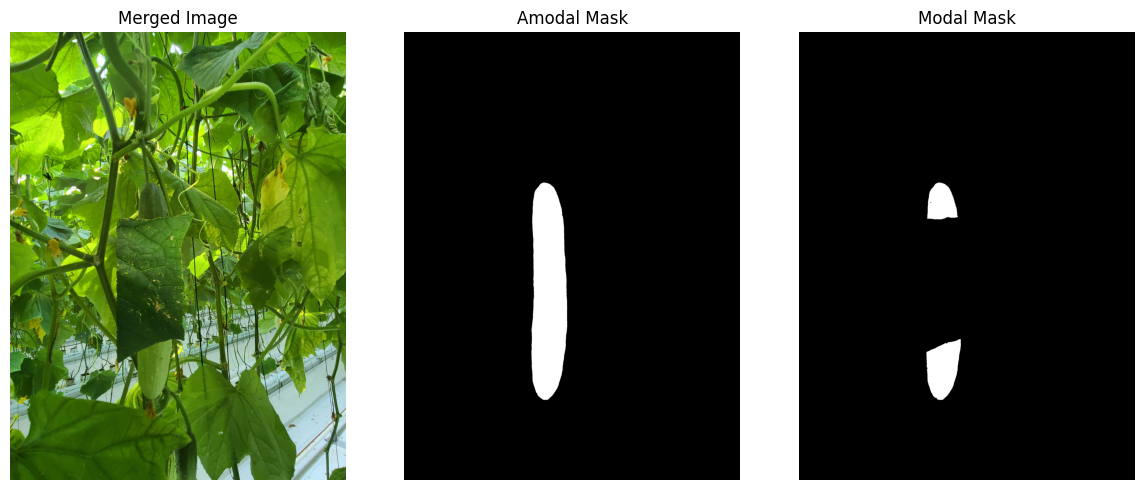

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


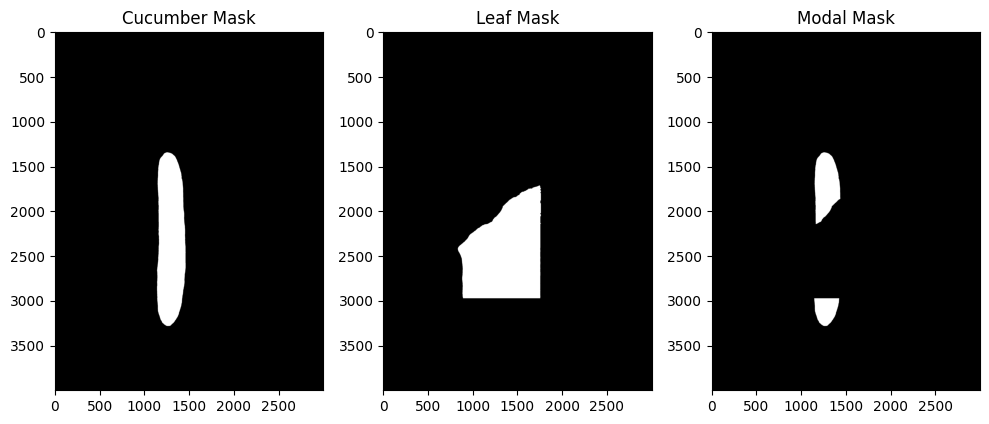

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


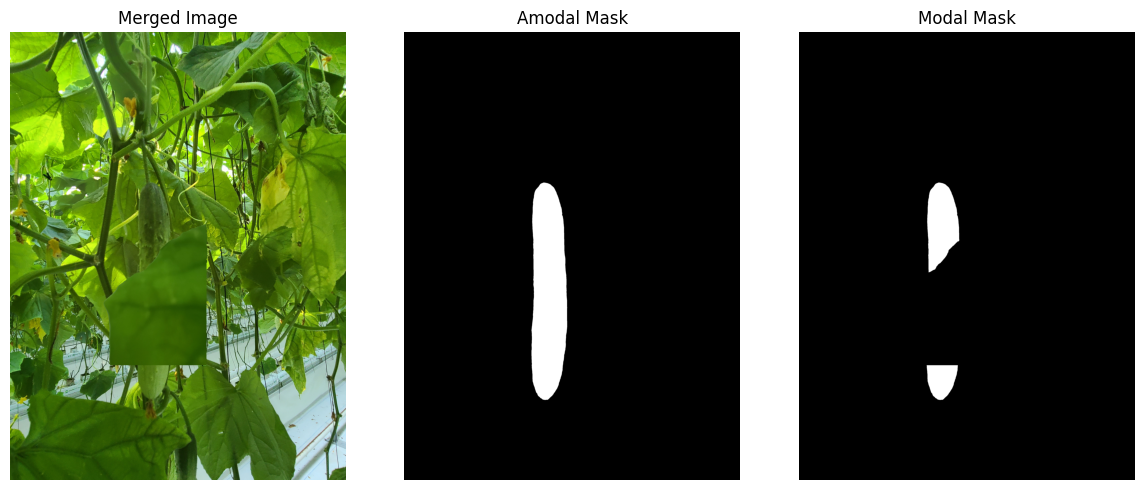

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_140_3.jpg
Modal 마스크 생성 시작...


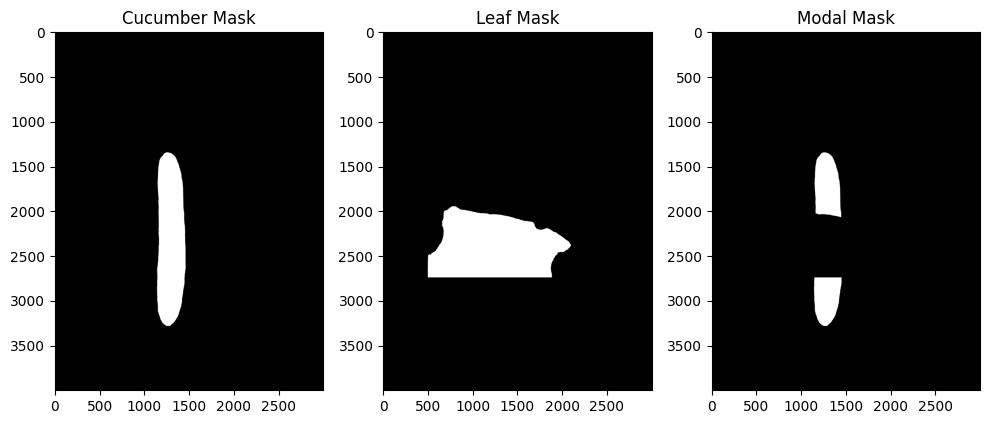

Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_140_3_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_140_3_amodal_info.json


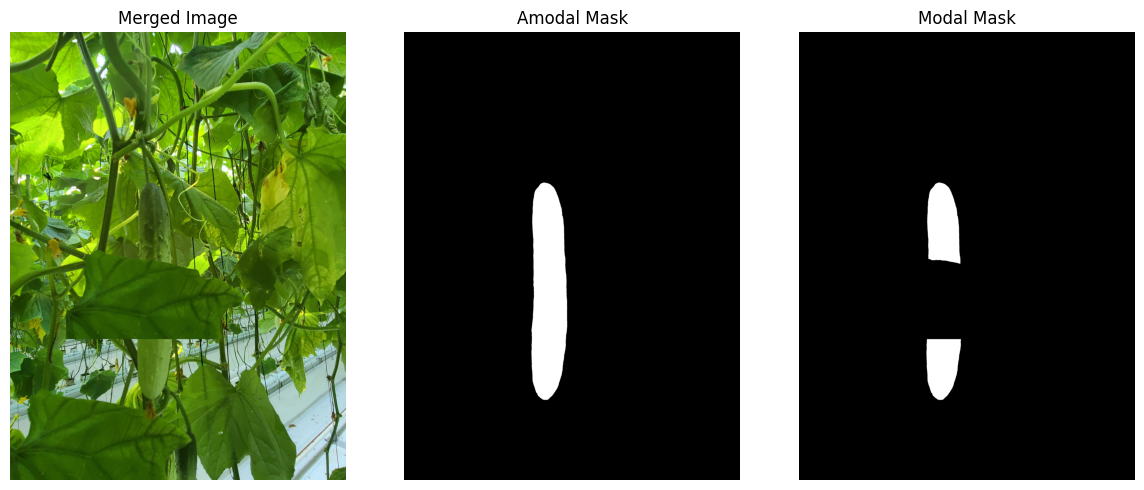

오이 이미지 합성 시작...


KeyboardInterrupt: 

In [5]:
# 특정 클래스 마스크만 선택 (클래스 0: 오이)
def get_cucumber_masks(mask_dir, image_name):
    cucumber_masks = []
    for mask_file in os.listdir(mask_dir):
        # 파일명이 이미지명과 매칭되고 클래스가 0인 마스크만 선택
        if mask_file.startswith(image_name) and '_0_' in mask_file:
            cucumber_masks.append(os.path.join(mask_dir, mask_file))
    return cucumber_masks

# 실행 예시
''' input'''
cucumber_images_dir = INPUT_PATHS["cucumber_images_dir"]
cucumber_masks_dir = INPUT_PATHS["cucumber_masks_dir"]
leaf_cropped_dir = INPUT_PATHS["leaf_cropped_dir"]

''' output dir'''
save_dir = OUTPUT_PATHS["save_dir"]
mask_save_dir = OUTPUT_PATHS["mask_save_dir"]
json_dir = OUTPUT_PATHS["json_dir"]
offset_y_range = HYPERPARAMETERS["offset_y_range"]
image_index_start = HYPERPARAMETERS["image_index_start"]

# cucumber 이미지 파일 불러오기
cucumber_image_paths = get_image_paths_from_folder(cucumber_images_dir)

# 각 cucumber 이미지에 대해 마스크와 잎 합성
for cucumber_image_path in cucumber_image_paths:
    image_index =0
    # 이미지 이름에서 확장자를 제거하여 기본 이미지명을 가져옴
    image_name = os.path.splitext(os.path.basename(cucumber_image_path))[0]
    
    # 해당 이미지의 오이 마스크들 가져오기 (클래스가 0인 것만)
    cucumber_mask_paths = get_cucumber_masks(cucumber_masks_dir, image_name)

    if len(cucumber_mask_paths) == 0:
        print(f"오이 마스크가 없습니다: {image_name}")
        continue

    # 잎 이미지 경로 선택 (임의의 하나 또는 여러 잎을 사용할 수 있음)
    leaf_cropped_image_paths = get_image_paths_from_folder(leaf_cropped_dir)
    print(f'{image_name}에 대한 {len(cucumber_mask_paths)}개의 마스크 확보...')
    
    # 오이 마스크와 잎 이미지 합성 처리
    for cucumber_mask_path in cucumber_mask_paths:
        print(f'{len(leaf_cropped_image_paths)} 개의 잎 이미지와 합성 시작...')

        for leaf_cropped_image_path in leaf_cropped_image_paths:
            image_index += 1
            # offset_y 값을 범위 내에서 무작위로 설정
            offset_y = random.randint(offset_y_range[0], offset_y_range[1])

            # 오이와 잎 이미지를 합성하는 함수 호출
            process_amodal_images_and_masks(
                cucumber_image_path,
                leaf_cropped_image_path,
                cucumber_mask_path,
                save_dir,
                mask_save_dir,
                json_dir,
                image_index,
                offset_y
            )


In [13]:
import os
import shutil

# 특정 클래스(잎 클래스 1) 이미지를 선택하여 다른 폴더로 복사
def copy_leaves_images(cropped_objects_dir, target_dir, class_id="1"):
    # 타겟 디렉토리가 없으면 생성
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # cropped_objects 폴더 내 파일들 탐색
    for file_name in os.listdir(cropped_objects_dir):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            # 파일명에서 클래스 정보를 추출 (예: cropped_oi_001_1_xx.png)
            parts = file_name.split('_')
            if len(parts) > 4 and parts[4] == class_id:  # 클래스가 4번째 위치에 있는지 확인
                source_file = os.path.join(cropped_objects_dir, file_name)
                target_file = os.path.join(target_dir, file_name)
                
                # 파일 복사
                shutil.copy2(source_file, target_file)
                print(f"복사 완료: {source_file} -> {target_file}")

# 경로 설정
cropped_objects_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects"
selected_cropped_leaves_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves"

# 잎 클래스(1) 이미지만 선택하여 복사
copy_leaves_images(cropped_objects_dir, selected_cropped_leaves_dir, class_id="1")


복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_054_2_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_054_2_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_139_3_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_139_3_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_221_3_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_221_3_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_100_2_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_100_2_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_008_3_1_01.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_lea